## Train pointwise ML model using first order gradients

Taking inspiration from LES gradient models we train a ML model using the first order gradients of velocity and slopes as input. The output will be the streamfunction. 

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax.training import train_state  # Useful dataclass to keep train state
from flax import linen as nn
from flax.training import checkpoints
import flax
flax.config.update('flax_use_orbax_checkpointing', True)

import optax

import xbatcher
import fsspec

import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import open_datatree

import sys
sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

#### Prepare the data

We already generated the training data using 5 km resolution channel simulations.

Then we make sure that they are all centered. 
We also limit the dT/dz, to make sure there is no division by zero. 

In [2]:
import os 
#PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

M2LINES_BUCKET ='gs://leap-persistent/dhruvbalwada/m2lines_transfer/'

Lsel = '50'
Lsel_int = int(Lsel)

ds = xr.open_zarr(f'{M2LINES_BUCKET}ML_data/ds_ML_'+Lsel+'km_3D')

ds_mask = open_datatree(f'{M2LINES_BUCKET}ML_data/ds_ML_masks', engine='zarr')[Lsel].to_dataset().maskC

In [3]:
try:
    os.mkdir('figures/'+Lsel+'km')
except:
    pass

In [4]:
# Not all variables generated were centered, so center them all now. 
ds_centered = hf.center_data(ds)

# limit T_z, so there is no division by 0. 
# In practice this changes almost no points, since even in the top layers T_z ~ 1e-4. 
ds_centered['T_z'] = (ds_centered['T_z'].where(ds_centered['T_z']>=5e-5, 5e-5)) #.isel(time=0, XC=0).plot(vmin=-6e-3)

In [5]:
# Add variables that are actually used in the model.
ds_centered['Sx'] = -ds_centered['T_x']/ds_centered['T_z']
ds_centered['Sy'] = -ds_centered['T_y']/ds_centered['T_z']

ds_centered['Sfnx'] =  - ds_centered['uT']/ds_centered['T_z']
ds_centered['Sfny'] =  - ds_centered['vT']/ds_centered['T_z']

In [6]:
# Sub-sample the data 
# this is done to improve speed, but also keep the number of samples the same between the different filter scales. 

sub_samp_fac = int(400/ Lsel_int) # this factor is compted relative to our lowest resolution model. 

ds_centered_small = ds_centered.isel( XC=slice(0,-1,sub_samp_fac), YC=slice(0,-1,sub_samp_fac) )
ds_centered_small = ds_centered_small.where(ds_mask>0.9999999, drop=True)  # drop edges where mask artefacts
ds_centered_small = ds_centered_small.sel(Z=slice(-200, -2700)) # drop boundary layers 
ds_centered_small = ds_centered_small.sel(YC=slice(400e3,1600e3)) # drop region similar to what was missing in 400km case

#### Set the input and output variables

In [7]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', #'U_zbyT_z',
                  'V_x', 'V_y', #'V_zbyT_z',
                  'Sx', 'Sy'] # , 'T_z'] # drop dependence on T_z, since it was not very relevant in ablation studies.

In [8]:
ds_ML_vars = xr.merge([ds_centered_small[output_channels], ds_centered_small[input_channels]])
ds_ML_vars_full = xr.merge([ds_centered[output_channels], ds_centered[input_channels]])

#### Normalize using std

In [9]:
try: 
    ds_std = xr.open_zarr('STD_'+Lsel+'_km.nc')
except:
    ds_std = hf.compute_std(ds_ML_vars, ds_mask, slice(0,100))
    ds_std.compute();
    ds_std.to_zarr('STD_'+Lsel+'_km.nc')

In [10]:
ds_ML_vars_norm = hf.normalize_ds(ds_ML_vars, ds_std)
ds_ML_vars_full_norm = hf.normalize_ds(ds_ML_vars_full, ds_std)

#### Split into training and test datasets

In [11]:
_, ds_test_full = hf.split_train_test(ds_ML_vars_full_norm, test_slice=slice(450,470))
ds_train, ds_test = hf.split_train_test(ds_ML_vars_norm)

In [12]:
%%time
# Load to CPU to make things go faster
ds_train.load();
ds_test.load();

CPU times: user 1min 24s, sys: 15.9 s, total: 1min 40s
Wall time: 1min 19s


In [13]:
ds_test_full.load();

#### Batch datasets

We remove NANs before we use xbatcher to create batches. 

In [14]:
ds_train_stacked = ds_train.stack(points=('XC','YC','Z','time'))
ds_test_stacked  = ds_test.stack(points=('XC','YC','Z','time'))

In [15]:
ds_train_stacked_nonan = ds_train_stacked.dropna('points', subset=['Sfnx'])
ds_test_stacked_nonan  = ds_test_stacked.dropna('points', subset=['Sfnx'])

In [16]:
npoints_train = len(ds_train_stacked_nonan['Sfnx'])
npoints_test = len(ds_test_stacked_nonan['Sfnx'])
print(npoints_train, npoints_test)

2857500 428625


In [17]:
ds_train_stacked_nonan_randomized = ds_train_stacked_nonan.isel(points=np.random.choice(npoints_train, size=npoints_train, replace=False))
ds_test_stacked_nonan_randomized  = ds_test_stacked_nonan.isel(points=np.random.choice(npoints_test, size=npoints_test, replace=False))

In [18]:
bgen_train = xbatcher.BatchGenerator(ds = ds_train_stacked_nonan_randomized, 
                               input_dims={},
                               batch_dims={'points': int(75600)}   )

bgen_test = xbatcher.BatchGenerator(ds = ds_test_stacked_nonan_randomized, 
                               input_dims={},
                               batch_dims={'points': int(75600)}   )

In [19]:
len(bgen_train), len(bgen_test)

(37, 5)

#### Setup ML model

Here we will use a fully connected neural network that takes the inputs and ouputs that were defined before. 

In [22]:
bias = True

In [23]:
model, params = ml_hf.initialize_model([24, 24, 2], len(input_channels) , bias=bias)

In [24]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(param_count)

818


In [25]:
# setup loss function
loss_grad_fn = jax.value_and_grad(ml_hf.mse) # more convenient function as it outputs both value and gradient.

In [26]:
# Setup optimizer 

learning_rate = .01 # .05 for 100, .01 for 100, .05 for 100
# Maybe useful if wanting to set learning rates manually: https://github.com/deepmind/optax/issues/4

# Initialize optimizer
tx = optax.adam(learning_rate=learning_rate)

# Define training state 
state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

In [27]:
# to track model
train_loss = np.array([])
test_loss = np.array([])

In [ ]:
# Setup Wandb

In [ ]:
%%time
# Main training loop

for i in range(201):
    n=0
    
    loss_temp = np.array([]) # temp array to save batches
    for batch in bgen_train:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_train = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_train = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        
        # Compute gradients and update parameters and optimizer state 
        loss_val, grads = loss_grad_fn(state.params, state.apply_fn, X_train, y_train)
        state = state.apply_gradients(grads=grads)
        
        loss_temp = np.append(loss_temp, loss_val)
    
    
    train_loss = np.append(train_loss, np.mean(loss_temp))
    
    test_loss_temp = np.array([])
    for batch in bgen_test:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_test = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_test = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        test_loss_temp = np.append(test_loss_temp, ml_hf.mse(state.params, state.apply_fn, X_test, y_test))
    
    test_loss = np.append(test_loss, np.mean(test_loss_temp))
    
    if i % 10  == 0:
        print(f'Train loss step {i}: ', train_loss[-1], f'test loss:', test_loss[-1])

In [ ]:
plt.plot(train_loss, label='Training loss, '+str(train_loss[-1]))
plt.plot(test_loss, label='Test loss'+str(test_loss[-1]))

plt.title('Loss curve for '+ Lsel+ 'km filter scale')
plt.grid()
plt.yscale('log')
plt.legend()

plt.savefig('figures/'+Lsel+'km'+'/loss_curve.png')

#### Save trained model

Save the state to use in Python notebook again

In [ ]:

# This needed to be changed because flax his migrated to orbax for saving checkpoints now. 
# We use the automatic options from https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html 

In [ ]:
# Save the checkpoint
CKPT_DIR = 'ckpts_'+Lsel+'_'+str(bias)
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=1, overwrite=True)

In [28]:
# Read back from the checkpoint
if bias==False:
    CKPT_DIR = 'ckpts_'+Lsel+'_'+str(bias)
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
else:
    CKPT_DIR = 'ckpts_'+Lsel
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

Save the weights and normalizations for using with MOM6 later.

In [35]:
# Zero pred 
y_pred_zero = state.apply_fn(state.params, np.zeros(6))

In [47]:
y_pred_zero[1]

Array(-0.03502557, dtype=float32)

In [43]:
input_norms = np.zeros((len(input_channels),))

for n, i in enumerate(input_channels):
    #print(i + '=' + str(ds_std[i].values))
    input_norms[n] = ds_std[i].values
    
output_norms = np.zeros((len(output_channels),))

for n, i in enumerate(output_channels):
    #print(i + '=' + str(ds_std[i].values))
    output_norms[n] = ds_std[i].values
    
ds_layers = xr.Dataset()

ds_layers['layer_sizes'] = xr.DataArray(np.array([len(input_channels),24, 24, len(output_channels)]).astype('int32'), dims=['num_layers'])

ds_layers['A0'] = xr.DataArray(np.array(state.params['params']['layers_0']['kernel']).astype('float32'), dims=['input', 'layer1'])
ds_layers['A1'] = xr.DataArray(np.array(state.params['params']['layers_1']['kernel']).astype('float32'), dims=['layer1', 'layer2'])
ds_layers['A2'] = xr.DataArray(np.array(state.params['params']['layers_2']['kernel']).astype('float32'), dims=['layer2', 'output'])

if bias:
    ds_layers['b0'] = xr.DataArray(np.array(state.params['params']['layers_0']['bias']).astype('float32'), dims=['layer1'])
    ds_layers['b1'] = xr.DataArray(np.array(state.params['params']['layers_1']['bias']).astype('float32'), dims=['layer2'])
    ds_layers['b2'] = xr.DataArray(np.array(state.params['params']['layers_2']['bias']).astype('float32'), dims=['output'])
else: 
    ds_layers['b0'] = xr.DataArray(np.zeros(24).astype('float32'), dims=['layer1'])
    ds_layers['b1'] = xr.DataArray(np.zeros(24).astype('float32'), dims=['layer2'])
    ds_layers['b2'] = xr.DataArray(np.zeros(len(output_channels)).astype('float32'), dims=['output'])
    
    
ds_layers['input_norms'] = xr.DataArray(input_norms.astype('float32'), dims=['input'])
ds_layers['output_norms'] = xr.DataArray(output_norms.astype('float32'), dims=['output'])
ds_layers['zero_bias'] = xr.DataArray(y_pred_zero.astype('float32'), dims=['output'])

In [44]:
ds_layers.to_netcdf('ann_params_'+Lsel+'km'+'_'+str(bias)+'.nc', mode='w')

#### Quick check to see if model did well

In [36]:
# Inference step
# y_pred = model.apply(params, X_test)

ds_test_full_no_edge = ds_test_full.where(ds_mask>0.999999).sel(Z=slice(-200, -2700))

n_pred = 10

y_pred = state.apply_fn(state.params, ds_test_full_no_edge.isel(time=slice(0,n_pred))[input_channels].to_array().transpose(...,'variable')) - y_pred_zero

dims = ds_test_full_no_edge.isel(time=slice(0,n_pred))[output_channels].to_array().transpose(...,'variable').dims
coords = ds_test_full_no_edge.isel(time=slice(0,n_pred))[output_channels].to_array().transpose(...,'variable').coords

ds_pred = xr.DataArray( y_pred, dims=dims, coords=coords).to_dataset(dim='variable')

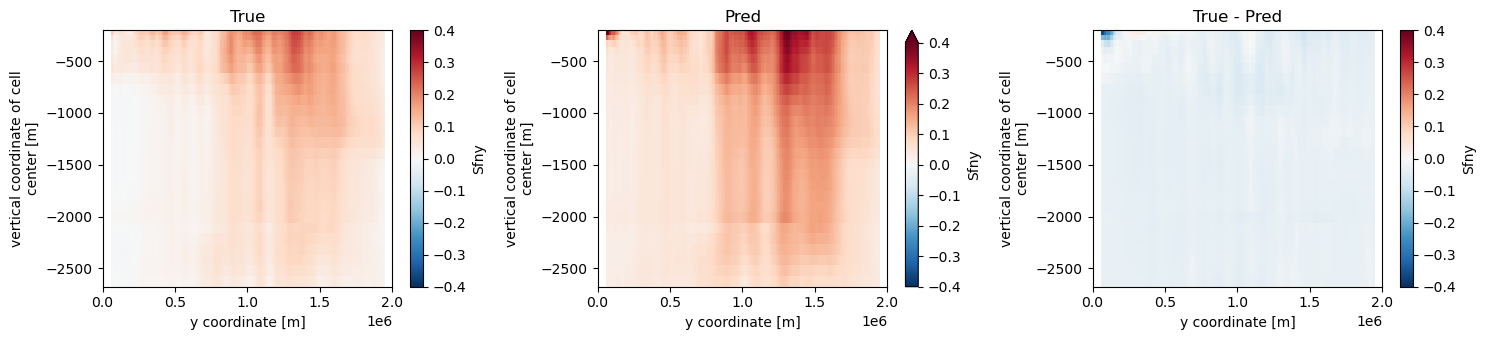

In [38]:
plt.figure(figsize=(15, 3.5))
           
plt.subplot(131)
ds_test_full_no_edge.Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('True')

plt.subplot(132)
ds_pred.Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('Pred')

plt.subplot(133)
(ds_test_full_no_edge-ds_pred).Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('True - Pred')


plt.tight_layout()

plt.savefig('figures/'+Lsel+'km'+'/zonal_avg'+'_'+str(bias)+'.png')

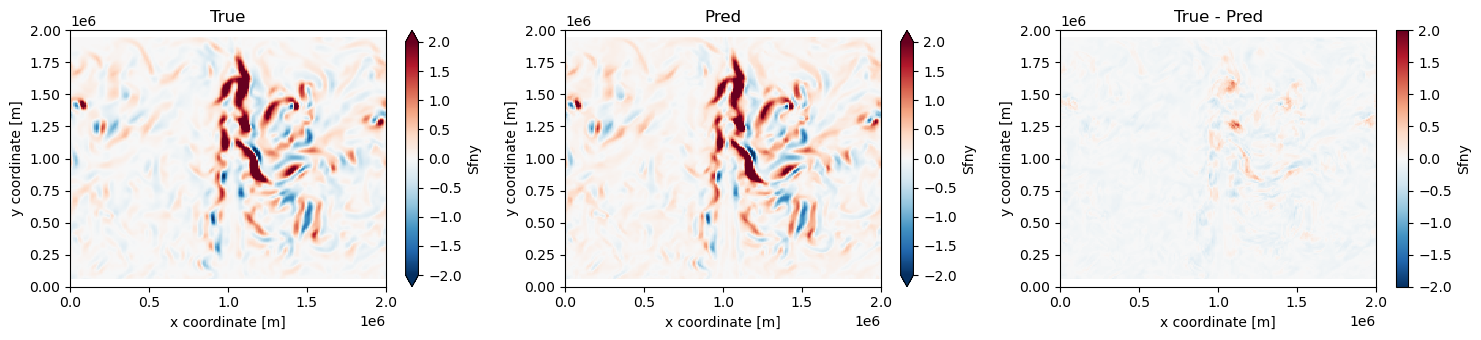

In [39]:
plt.figure(figsize=(15, 3.5))
zlev=-15
vlevs = 2.
plt.subplot(131)
ds_test_full_no_edge.Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')

plt.subplot(132)
ds_pred.Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('Pred')

plt.subplot(133)
(ds_test_full_no_edge-ds_pred).Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('True - Pred')


plt.tight_layout()
plt.savefig('figures/'+Lsel+'km'+'/XY_section'+'_'+str(bias)+'.png')

In [40]:
R2_XY = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','Z'])
R2_XZ = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','YC'])
R2_YZ = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','XC'])

R2_uT = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','Z','XC','YC'])
R2_vT = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfny', ['time','Z','XC','YC'])

R2_uT_z = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','XC','YC'])
R2_vT_z = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfny', ['time','XC','YC'])

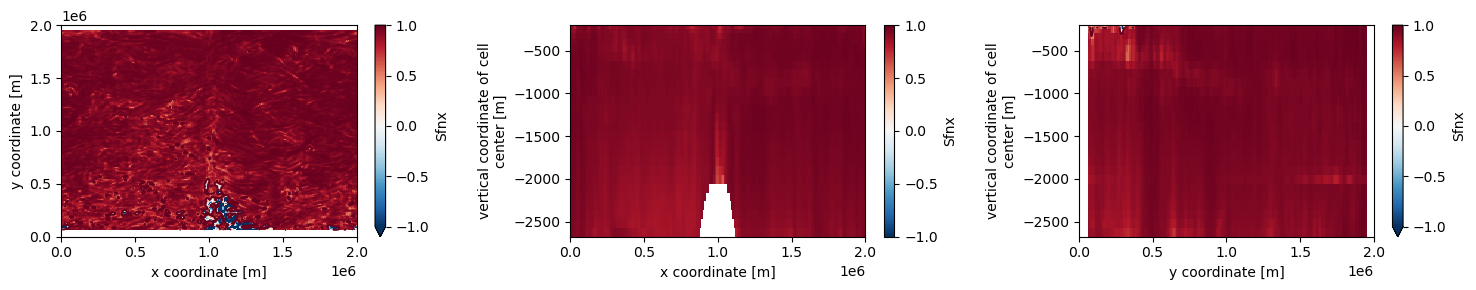

In [41]:
plt.figure(figsize=(15, 3))
           
vlim = 1.

plt.subplot(131)
R2_XY.plot(x='XC', vmin=-vlim)
R2_XY.plot.contour(levels=[0.5], x='XC', vmin=-vlim)

plt.subplot(132)
R2_XZ.plot(x='XC', vmin=-vlim)
R2_XZ.plot.contour(levels=[0.5], x='XC', vmin=-vlim)

plt.subplot(133)
R2_YZ.plot(x='YC', vmin=-vlim)
R2_YZ.plot.contour(levels=[0.5], x='YC', vmin=-vlim)

plt.tight_layout()

plt.savefig('figures/'+Lsel+'km'+'/R2_sections'+'_'+str(bias)+'.png')

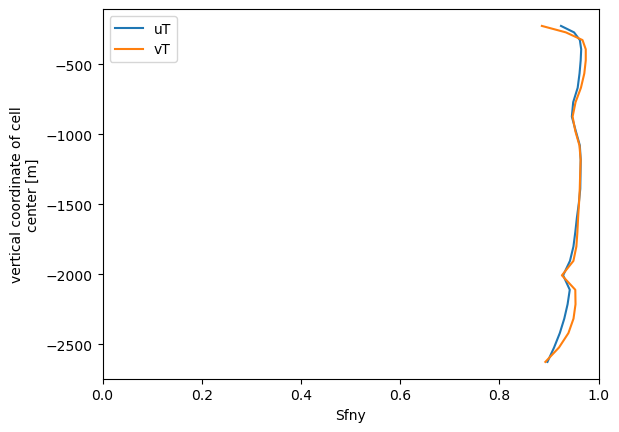

In [42]:
R2_uT_z.plot(y='Z', label='uT')
R2_vT_z.plot(y='Z', label='vT')
plt.xlim([0,1])
plt.legend()

plt.savefig('figures/'+Lsel+'km'+'/R2_profile.png')

## Fin